# Elliptic Stadium Billiard Simulation

This notebook implements a numerical simulation of classical particle motion in an elliptic stadium geometry with perfectly reflecting boundaries. The stadium consists of a rectangular region capped by semi-elliptical ends.

## Part A: Classical Motion (Newtonian Dynamics)

The objectives of this simulation are:
1. Numerically integrate Newton's equations for a free particle with elastic collisions
2. Plot particle trajectories for both short-time (few bounces) and long-time behavior
3. Investigate ergodic coverage and chaotic dynamics through sensitivity to initial conditions
4. Verify physical conservation laws (energy) and reflection properties

**Stadium Geometry**: Rectangle of half-length `a` and vertical extent `±b`, with elliptical caps of semi-axes `(rx, ry)` centered at `(±a, 0)`.

## 1. Setup and Geometry Parameters

This cell imports necessary libraries and defines the geometry of our elliptic stadium billiard:

- Rectangle dimensions: Half-length `a=2.0`, vertical extent `b=1.0` (spanning x ∈ [-2,2], y ∈ [-1,1])
- Elliptical caps: Semi-axes `rx=2.5`, `ry=0.5` centered at `(±a, 0)`
  - Note: When `ry = b` the ellipse joins the rectangle smoothly at `y = ±b`.
  - When `ry ≠ b`, the stadium boundary includes vertical join segments at `x=±a` for `|y| ∈ (min(b, ry), max(b, ry))`.
- Physical parameters: Particle speed `v=1.0` (unit mass, so kinetic energy = 0.5)
- Numerical precision: Small epsilon `_EPS=1e-12` for collision detection

The stadium boundary is the union of the rectangular strip and two half-ellipses:
- Ellipse caps satisfy: `((x−c_x)^2)/r_x^2 + (y^2)/r_y^2 = 1` (with centers `c_x=±a`).
- Vertical join segments appear only when `ry ≠ b` (which is the case here since ry=0.5 ≠ b=1.0).

In [1]:
# Cell 1 — Setup (Part A: Classical Motion) — Elliptic Stadium Billiard
# Source doc: Team Assignment 1  :contentReference[oaicite:0]{index=0}

import numpy as np
import matplotlib.pyplot as plt

# ---- Geometry parameters (feel free to tweak) ----
a  = 2         # half-length of rectangle along x  -> rectangle spans x in [-a, a]
b  = 1         # vertical extent of rectangle     -> y in [-b, b]
rx = 2.5         # ellipse semi-axis along x for caps (right cap centered at +a, left at -a)
ry = 0.5           # ellipse semi-axis along y (set equal to b for smooth join with rectangle)

# Simulation parameters
speed = 1.0      # particle speed (mass m=1, so E = 0.5*speed^2)
rng_seed = 7
np.random.seed(rng_seed)

# Small numerical epsilon
_EPS = 1e-12


## 2. Collision Detection and Reflection Laws

This cell implements the core physics for particle-boundary interactions:

### Key Functions:
- `_ellipse_intersections()`: Solves the quadratic equation for line–ellipse intersections
- `next_collision()`: Finds the next boundary collision point and applies the law of reflection

### Physics Implementation:
1. Ray–boundary intersection: Parametric line `(x,y) = (x0,y0) + t(vx,vy)` intersected with stadium boundary
2. Reflection law: `v_reflected = v_in − 2 (v_in · n̂) n̂` where `n̂` is the outward unit normal
3. Boundary normals:
   - Rectangle edges: `n̂ = (0, ±1)` for horizontal walls `y=±b`
   - Vertical join segments (present only if `ry ≠ b`): `n̂ = (±1, 0)` with sign chosen by the outward direction
   - Ellipse caps: `n̂ ∝ ∇F`, with `F(x,y) = ((x−c_x)^2)/r_x^2 + (y^2)/r_y^2 − 1`

This ensures exact specular reflection at all boundary points, including the vertical joins when `ry ≠ b`.

In [2]:
# Cell 2 — Geometry helpers & collision solver (law of reflection via boundary normals)

def _ellipse_intersections(x0, y0, vx, vy, cx, rx, ry, eps=_EPS):
    """
    Intersections of parametric line (x,y)=(x0,y0)+t(vx,vy) with ellipse:
        ((x - cx)^2)/rx^2 + (y^2)/ry^2 = 1
    Returns list of (t, x, y) with t > eps.
    """
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*((x0 - cx)*vx/(rx*rx) + y0*vy/(ry*ry))
    C = ((x0 - cx)**2)/(rx*rx) + (y0**2)/(ry*ry) - 1.0

    disc = B*B - 4*A*C
    hits = []
    if A != 0 and disc >= 0:
        sqrt_disc = np.sqrt(max(0.0, disc))
        for t in ((-B - sqrt_disc)/(2*A), (-B + sqrt_disc)/(2*A)):
            if t > eps:
                x = x0 + vx*t
                y = y0 + vy*t
                hits.append((t, x, y))
    return hits


def next_collision(x0, y0, vx, vy, a, b, rx, ry, eps=_EPS):
    """
    Compute next boundary hit and reflected velocity.
    Stadium boundary = rectangle (top/bottom edges at y=±b, for |x|<=a)
                    + right half-ellipse centered at (a,0)
                    + left  half-ellipse centered at (-a,0)
                    + vertical join segments at x=±a when b ≠ ry (for |y|∈(min(b,ry), max(b,ry)))
    Returns: (t_hit, x_hit, y_hit, vx_ref, vy_ref, n_hat, kind)  or None if no hit.
    """
    candidates = []

    # Horizontal top (y=+b) inside the rectangle span |x|<=a
    if vy > eps:
        t = (b - y0)/vy
        if t > eps:
            x_at = x0 + vx*t
            if -a - 1e-12 <= x_at <= a + 1e-12:
                candidates.append(("top", t, x_at, b))

    # Horizontal bottom (y=-b)
    if vy < -eps:
        t = (-b - y0)/vy
        if t > eps:
            x_at = x0 + vx*t
            if -a - 1e-12 <= x_at <= a + 1e-12:
                candidates.append(("bottom", t, x_at, -b))

    # Vertical join segments at x=±a when ry != b
    y_low = min(b, ry)
    y_high = max(b, ry)
    tol = 1e-12
    if abs(vx) > eps and (y_high - y_low) > tol:
        # Right vertical at x = +a
        t = (a - x0)/vx
        if t > eps:
            y_at = y0 + vy*t
            if (abs(y_at) > y_low + tol) and (abs(y_at) < y_high - tol):
                candidates.append(("vright", t, a, y_at))
        # Left vertical at x = -a
        t = (-a - x0)/vx
        if t > eps:
            y_at = y0 + vy*t
            if (abs(y_at) > y_low + tol) and (abs(y_at) < y_high - tol):
                candidates.append(("vleft", t, -a, y_at))

    # Right cap (center at +a): keep only the half with x >= a
    for t, x_at, y_at in _ellipse_intersections(x0, y0, vx, vy, a, rx, ry, eps):
        if x_at >= a - 1e-12:
            candidates.append(("ellipse_right", t, x_at, y_at))

    # Left cap (center at -a): keep only the half with x <= -a
    for t, x_at, y_at in _ellipse_intersections(x0, y0, vx, vy, -a, rx, ry, eps):
        if x_at <= -a + 1e-12:
            candidates.append(("ellipse_left", t, x_at, y_at))

    if not candidates:
        return None

    # Select earliest positive hit
    kind, tmin, xh, yh = min(candidates, key=lambda w: w[1])

    # Outward unit normal at the hit point
    if kind == "top":
        n = np.array([0.0, 1.0])
    elif kind == "bottom":
        n = np.array([0.0, -1.0])
    elif kind == "ellipse_right":
        # F = ((x-a)^2)/rx^2 + (y^2)/ry^2 - 1;  ∇F gives normal
        n = np.array([2*(xh - a)/(rx*rx), 2*yh/(ry*ry)])
    elif kind == "ellipse_left":
        n = np.array([2*(xh + a)/(rx*rx), 2*yh/(ry*ry)])
    elif kind == "vright":
        # For x=+a vertical: outward is to the side that's outside the union
        # If |y| > b (ellipse-only interior), outside is to the left => n = (-1, 0)
        # If |y| < b (rectangle-only interior), outside is to the right => n = (1, 0)
        n = np.array([-1.0, 0.0]) if abs(yh) > b else np.array([1.0, 0.0])
    else:  # "vleft"
        # For x=-a vertical: if |y| > b, interior is to the left (ellipse), outside right => n=(+1,0)
        # else interior is to the right (rectangle), outside left => n=(-1,0)
        n = np.array([1.0, 0.0]) if abs(yh) > b else np.array([-1.0, 0.0])

    n_hat = n / np.linalg.norm(n)
    v = np.array([vx, vy])
    v_ref = v - 2*np.dot(v, n_hat)*n_hat  # specular reflection

    return tmin, xh, yh, float(v_ref[0]), float(v_ref[1]), n_hat, kind


## 3. Billiard Simulation Engine and Visualization

This cell contains the main simulation engine and boundary visualization utilities:

### Core Simulation Function:
- `simulate_billiard()`: Iteratively computes particle trajectory through successive collisions
  - Tracks position at each bounce
  - Records velocity before/after each collision  
  - Monitors energy and collision statistics
  - Includes numerical safeguards (tiny velocity nudges to prevent re-collision)

### Visualization Tools:
- `stadium_boundary_points()`: Generates boundary curve points for plotting (tops/bottoms, ellipse caps, and vertical join segments if `ry ≠ b`)
- `plot_stadium()`: Draws the complete boundary with aspect ratio preserved; y-limits use `max(b, ry)`

### Output Data Structure:
The simulation returns comprehensive trajectory data including bounce points, velocities, boundary normals, collision types, and energy time series for post-processing analysis.

In [3]:
# Cell 3 — Simulator + boundary plotting utility


def simulate_billiard(initial_state, params, max_bounces=1000, eps=_EPS):
    """
    Straight-line flights with exact specular reflections at the stadium boundary.
    Returns dict with trajectory end points (at each bounce), energy series, normals, etc.
    """
    a, b, rx, ry = params["a"], params["b"], params["rx"], params["ry"]
    x, y, vx, vy = initial_state
    v0 = np.hypot(vx, vy)

    xs, ys = [x], [y]
    v_in_list, v_out_list = [], []
    bounce_pts, normals, kinds = [], [], []
    energies = []

    for k in range(max_bounces):
        energies.append(0.5 * (vx * vx + vy * vy))
        vin = np.array([vx, vy])

        hit = next_collision(x, y, vx, vy, a, b, rx, ry, eps)
        if hit is None:
            break

        t_hit, xh, yh, vx_new, vy_new, n_hat, kind = hit
        vout = np.array([vx_new, vy_new])

        # Move to hit point, then nudge slightly along the *new* velocity to avoid re-hitting due to roundoff
        x = xh + vx_new * 1e-9
        y = yh + vy_new * 1e-9

        xs.append(x)
        ys.append(y)
        bounce_pts.append((xh, yh))
        normals.append(n_hat)
        kinds.append(kind)
        v_in_list.append(vin)
        v_out_list.append(vout)

        vx, vy = vx_new, vy_new

    # record last energy as well
    energies.append(0.5 * (vx * vx + vy * vy))

    return {
        "x": np.array(xs),
        "y": np.array(ys),
        "bounce_pts": np.array(bounce_pts),
        "normals": np.array(normals),
        "kinds": kinds,
        "v_in": np.array(v_in_list),
        "v_out": np.array(v_out_list),
        "energies": np.array(energies),
        "speed0": v0,
        "v_last": np.array([vx, vy]),
    }


def stadium_boundary_points(a, b, rx, ry, num=400):
    """Points describing the stadium boundary for plotting."""
    # Rectangle top/bottom
    xs = np.linspace(-a, a, num)
    top = (xs, np.full_like(xs, b))
    bottom = (xs, np.full_like(xs, -b))

    # Right half-ellipse (theta in [-pi/2, pi/2])
    t = np.linspace(-np.pi / 2, np.pi / 2, num)
    xr = a + rx * np.cos(t)
    yr = ry * np.sin(t)

    # Left half-ellipse (mirror)
    xl = -a - rx * np.cos(t)
    yl = ry * np.sin(t)

    # Vertical join segments at x=±a when ry != b
    segs = []
    if not np.isclose(ry, b):
        y_low, y_high = sorted([b, ry])
        ys = np.linspace(y_low, y_high, max(2, num//6))
        segs.append(((np.full_like(ys, a), ys), (np.full_like(ys, a), -ys)))
        segs.append(((-np.full_like(ys, a), ys), (-np.full_like(ys, a), -ys)))

    return top, bottom, (xr, yr), (xl, yl), segs


def plot_stadium(ax, a, b, rx, ry, **kw):
    top, bottom, right_cap, left_cap, segs = stadium_boundary_points(a, b, rx, ry)
    ax.plot(*top, **kw)
    ax.plot(*bottom, **kw)
    ax.plot(*right_cap, **kw)
    ax.plot(*left_cap, **kw)
    for (x1, y1), (x2, y2) in segs:
        ax.plot(x1, y1, **kw)
        ax.plot(x2, y2, **kw)
    ax.set_aspect("equal", "box")
    ax.set_xlim(-a - rx - 0.1, a + rx + 0.1)
    ax.set_ylim(-max(b, ry) - 0.1, max(b, ry) + 0.1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Elliptic Stadium Boundary")

## 4. Physical Validation and Sanity Checks

This cell implements critical validation functions to verify the simulation's physical accuracy:

### Validation Functions:

1. **`reflection_check()`**: Verifies the law of reflection
   - Tests: $(\vec{v}_{in} \cdot \hat{n}) + (\vec{v}_{out} \cdot \hat{n}) \approx 0$ at each bounce
   - Should be zero for perfect specular reflection

2. **`energy_check()`**: Monitors energy conservation
   - Tracks: $E = \frac{1}{2}|\vec{v}|^2$ throughout trajectory
   - Reports relative drift from initial energy

3. **`sensitivity_to_initial_conditions()`**: Diagnostic for chaotic behavior
   - Compares two trajectories with infinitesimally different initial conditions
   - Measures separation distance at corresponding bounce points
   - Exponential growth indicates sensitive dependence (chaos)

These checks are essential for validating the numerical implementation and identifying potential sources of error in the collision detection or integration schemes.

In [4]:
# Cell 4 — Sanity-check helpers (reflection & energy), plus sensitivity to initial conditions

def reflection_check(sim):
    """Check specular reflection: (v_in · n) + (v_out · n) ≈ 0 at each bounce."""
    vin = sim["v_in"]; vout = sim["v_out"]; normals = sim["normals"]
    res = []
    for i in range(len(vin)):
        n = normals[i] / np.linalg.norm(normals[i])
        res.append(np.dot(vin[i], n) + np.dot(vout[i], n))
    res = np.array(res)
    return dict(max_abs=float(np.max(np.abs(res))), mean_abs=float(np.mean(np.abs(res))), residuals=res)


def energy_check(sim):
    """Energy conservation: relative drift of E = (|v|^2)/2."""
    E = sim["energies"]
    rel = np.abs((E - E[0]) / E[0])
    return dict(max_rel=float(np.max(rel)), mean_rel=float(np.mean(rel)), series=rel)


def sensitivity_to_initial_conditions(state1, state2, params, max_bounces=600):
    """
    Run two trajectories with slightly different initial conditions.
    Compare distances at corresponding bounce points.
    """
    s1 = simulate_billiard(state1, params, max_bounces=max_bounces)
    s2 = simulate_billiard(state2, params, max_bounces=max_bounces)
    P1, P2 = s1["bounce_pts"], s2["bounce_pts"]
    m = min(len(P1), len(P2))
    if m == 0:
        return np.array([]), s1, s2
    d = np.linalg.norm(P1[:m] - P2[:m], axis=1)
    return d, s1, s2


## 5. Short-Time Trajectory Analysis

This cell demonstrates the billiard simulation for a limited number of bounces to clearly visualize the particle's path and validate our implementation:

### Simulation Parameters:
- Initial condition: Particle starts at center (0,0) with angle θ = 0.6 radians
- Trajectory length: Up to 100,000 bounces (will likely terminate earlier for visualization)
- Speed: Unit speed (v = 1.0)

### Visualizations:
- Trajectory plot: Shows particle path with bounce points marked as circles
- Stadium boundary: Overlaid to show collision points; since `ry ≠ b`, the vertical join segments at `x=±a` are drawn as well

### Validation Results:
The simulation reports:
1. Reflection accuracy: Maximum deviation from perfect specular reflection law
2. Energy conservation: Relative energy drift over the trajectory

Expected results: Both should be near machine precision for a properly implemented collision algorithm, even when `ry ≠ b`.

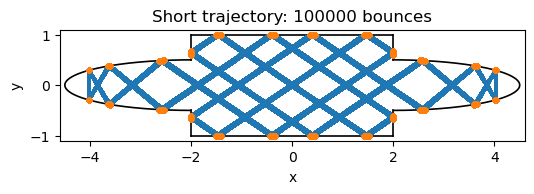

Reflection check: max |(v_in·n)+(v_out·n)| = 9.992e-16    mean = 8.713e-17
Energy check: max relative drift = 1.297e-13    mean = 4.985e-14


In [5]:
# Cell 5 — Short-time trajectory (a few bounces) + sanity checks

params = dict(a=a, b=b, rx=rx, ry=ry)

# Example initial condition: start near center, random-ish direction
theta = 0.6  # radians
x0, y0 = 0.0, 0.0
vx0, vy0 = speed*np.cos(theta), speed*np.sin(theta)
state = (x0, y0, vx0, vy0)

short_bounces = 100000
sim_short = simulate_billiard(state, params, max_bounces=short_bounces)

# Plot short trajectory
fig, ax = plt.subplots(figsize=(6, 5))
plot_stadium(ax, a, b, rx, ry, color='k', linewidth=1.2)
ax.plot(sim_short["x"], sim_short["y"], '-', lw=1.8)
ax.plot(sim_short["bounce_pts"][:,0], sim_short["bounce_pts"][:,1], 'o', ms=3)
ax.set_title(f"Short trajectory: {len(sim_short['bounce_pts'])} bounces")
plt.show()

# Sanity checks
refl = reflection_check(sim_short)
ener = energy_check(sim_short)

print("Reflection check: max |(v_in·n)+(v_out·n)| =", f"{refl['max_abs']:.3e}",
      "   mean =", f"{refl['mean_abs']:.3e}")
print("Energy check: max relative drift =", f"{ener['max_rel']:.3e}",
      "   mean =", f"{ener['mean_rel']:.3e}")


## 5b. Solution 2 — Numerical time-stepping (comparison with Solution 1)

This alternative approach integrates the motion with small time steps and detects boundary crossings numerically (with backtracking/halving) instead of solving exact intersection equations. It’s more "numerical" and may accumulate discretization error, but is simple to implement. Below we implement Solution 2 and then compare it with Solution 1 (exact collision solver).

### Helpers for Solution 2

Utility functions used by the numerical time-stepping approach: inside-domain check, boundary classification (vertical/horizontal/ellipse), shape-based slope estimate at the boundary, and a small angle helper.

In [6]:
# --- Solution 2 helpers (ported from SectionA-Solution2.ipynb) ---
import numpy as _np
import math as _math

try:
    a, b, rx, ry
except NameError:
    a, b, rx, ry = 2, 1, 2.5, 0.5


def s2_is_inside(x, y, a, b, rx, ry, v0, min_T):
    if abs(y) > b:
        return False
    X = abs(x)
    right_eq = (X - a) ** 2 / (rx ** 2) + (y ** 2) / (ry ** 2)
    if X > a and right_eq > 1:
        return False
    return True


def s2_shape(x, y, a, b, rx, ry):
    X = abs(x)
    if X <= a:
        return _np.sign(y) * b if y != 0 else b
    newY = ((ry) ** 2 * (1 - (X - a) ** 2 / (rx) ** 2)) ** 0.5
    return newY if y >= 0 else -newY


def s2_derivative(x, y, a, b, rx, ry):
    min_X = 1e-15
    return (s2_shape(x + min_X, y, a, b, rx, ry) - s2_shape(x - min_X, y, a, b, rx, ry)) / (2 * min_X)


def s2_boundary_type(x, y, a, b, rx, ry, tol=1e-6):
    ax, ay = abs(x), abs(y)
    if abs(ax - a) <= tol and (ry + tol) <= ay <= (b + tol):
        return 'vertical'
    if ay >= (b - tol) and ax <= (a + tol):
        return 'horizontal'
    return 'ellipse'


def s2_make_angle_positive(theta):
    return theta + _np.pi if theta < 0 else theta

### Numerical stepping loop (Solution 2)

Advance the particle with small time steps. If a step leaves the domain, backtrack and halve the step; when the step becomes tiny, register a collision and reflect based on local boundary type.

In [7]:
# --- Solution 2 main loop (numerical stepping with backtracking) ---

# Initial condition similar to Solution 1 for fair comparison
x2, y2 = 2.0, 0.0
v0_2 = 1.0
th2 = 0.0  # radians
vx2, vy2 = v0_2 * _np.cos(th2), v0_2 * _np.sin(th2)

min_T = 1e-3
points2 = []
collision_count2 = 0

for i in range(500000):  # fewer steps to keep it responsive
    points2.append([x2, y2])
    if not s2_is_inside(x2, y2, a, b, rx, ry, v0_2, min_T):
        # backtrack and reduce step
        x2 -= min_T * vx2
        y2 -= min_T * vy2
        min_T *= 0.5

    if min_T < 1e-14:
        collision_count2 += 1
        min_T = 1e-3
        btype = s2_boundary_type(x2, y2, a, b, rx, ry)
        if btype == 'vertical':
            th2 = _np.arctan2(vy2, -vx2)
        elif btype == 'horizontal':
            th2 = _np.arctan2(-vy2, vx2)
        else:
            alpha = s2_make_angle_positive(_math.atan(s2_derivative(x2, y2, a, b, rx, ry))) - th2 - _np.pi / 2
            th2 += 2 * alpha + _np.pi
        vx2, vy2 = v0_2 * _np.cos(th2), v0_2 * _np.sin(th2)

    x2 += min_T * vx2
    y2 += min_T * vy2

points2 = _np.array(points2)


### Comparison: exact vs numerical

Left: Solution 1 exact collision solver; Right: Solution 2 numerical trajectory. The title shows bounce count (S1) and detected collision count (S2).

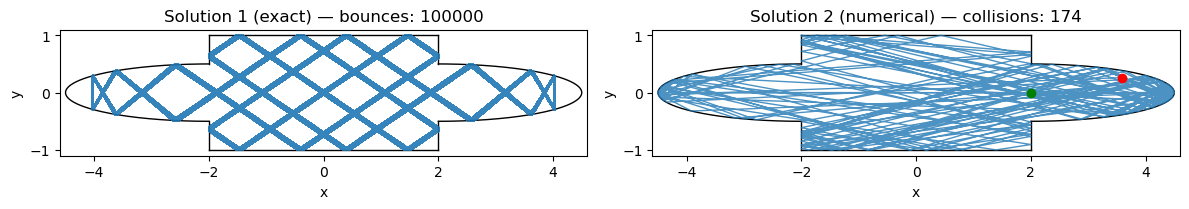

Comparison summary:
- Solution 1 (exact): bounces recorded = 100000
- Solution 2 (numerical): wall collisions counted = 174


In [30]:
# --- Comparison plots: Solution 1 (exact) vs Solution 2 (numerical) ---

# Ensure we have a reference Solution 1 short run (reuse earlier sim_short if available)
try:
    sim_short
except NameError:
    params = dict(a=a, b=b, rx=rx, ry=ry)
    theta = 0.0
    state = (2.0, 0.0, speed*np.cos(theta), speed*np.sin(theta)) if 'speed' in globals() else (2.0, 0.0, 1.0, 0.0)
    sim_short = simulate_billiard(state, params, max_bounces=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: Solution 1 exact
plot_stadium(axes[0], a, b, rx, ry, color='k', linewidth=1.0)
axes[0].plot(sim_short["x"], sim_short["y"], '-', lw=1.2, alpha=0.9)
axes[0].set_title(f"Solution 1 (exact) — bounces: {len(sim_short['bounce_pts'])}")

# Right: Solution 2 numerical
plot_stadium(axes[1], a, b, rx, ry, color='k', linewidth=1.0)
axes[1].plot(points2[:,0], points2[:,1], '-', lw=1.0, alpha=0.8)
axes[1].plot(points2[0,0], points2[0,1], 'go', ms=6)
axes[1].plot(points2[-1,0], points2[-1,1], 'ro', ms=6)
axes[1].set_title(f"Solution 2 (numerical) — collisions: {collision_count2}")

plt.tight_layout()
plt.show()

# Numeric comparisons
print("Comparison summary:")
print(f"- Solution 1 (exact): bounces recorded = {len(sim_short['bounce_pts'])}")
print(f"- Solution 2 (numerical): wall collisions counted = {collision_count2}")

#### Why do the two methods differ?

- Model of impact detection:
  - Solution 1 computes exact intersection with the boundary and reflects using the analytic normal; this avoids time-discretization drift.
  - Solution 2 advances with finite time steps and "backtracks+halves" when exiting; the hit point and normal are approximated.
- Step-size sensitivity (min_T):
  - In Solution 2, smaller `min_T` gives closer-to-exact hits but increases runtime; larger `min_T` can miss grazing contacts or shift impact locations.
- Boundary classification near joins (ry ≠ b):
  - The vertical/horizontal/ellipse switch uses tolerances; small differences around x=±a and y=±b can change which normal is used and thus the outgoing angle.
- Derivative-based normal on ellipses (S2):
  - The slope is estimated numerically (finite difference) and can be noisy near corners/joins, altering reflection slightly.
- Collision counting definition:
  - S1 counts bounces exactly from the solver; S2 increments when `min_T` falls below a threshold. With different dynamics, the counts may diverge.

Practical tips:
- If you want closer agreement, reduce `min_T` and the tolerance in boundary classification for S2.
- For speed with accuracy, prefer S1 for precise geometry interactions; use S2 for quick prototyping or when exact intersections are hard to code.

## 6. Long-Time Trajectory and Ergodic Coverage

This cell extends the simulation to demonstrate the long-term behavior of the billiard system:

### Extended Simulation:
- Duration: 3000 bounces to observe ergodic-like coverage
- Same initial conditions as the short trajectory for comparison

### Expected Behavior:
In chaotic billiard systems, long trajectories typically exhibit:
1. Ergodic coverage: The particle eventually visits most regions of the available phase space
2. Dense boundary interactions: Uniform sampling of boundary collision points (including vertical joins when `ry ≠ b`)
3. Maintained energy conservation: Even over extended time periods

### Notes on Geometry:
When `ry ≠ b`, the presence of vertical join segments at `x=±a` does not affect the formulation of specular reflection and is fully handled by the solver and plots.

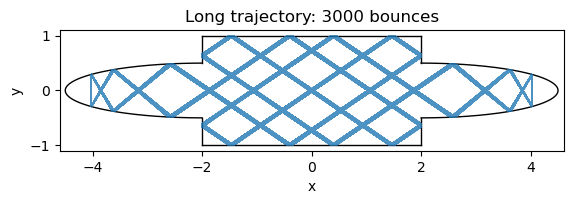

Energy drift over long run: max rel = 1.266e-14   mean rel = 4.362e-15


In [10]:
# Cell 6 — Long-time trajectory (ergodic-like coverage)

long_bounces = 3000  # increase for denser coverage (e.g., 10_000 if needed)
sim_long = simulate_billiard(state, params, max_bounces=long_bounces)

fig, ax = plt.subplots(figsize=(6.5, 5.2))
plot_stadium(ax, a, b, rx, ry, color='k', linewidth=1.0)
ax.plot(sim_long["x"], sim_long["y"], '-', lw=0.7, alpha=0.8)
ax.set_title(f"Long trajectory: {len(sim_long['bounce_pts'])} bounces")
plt.show()

ener_long = energy_check(sim_long)
print("Energy drift over long run: max rel =", f"{ener_long['max_rel']:.3e}",
      "  mean rel =", f"{ener_long['mean_rel']:.3e}")


## 7. Sensitivity to Initial Conditions - Chaos Diagnostic

This cell investigates the chaotic nature of the billiard system through sensitivity analysis:

### Methodology:
1. **Perturbed initial conditions**: Two trajectories with initial angles differing by δθ = 10⁻⁶ radians
2. **Trajectory comparison**: Measure separation distance at corresponding bounce points
3. **Growth rate analysis**: Fit exponential growth to quantify sensitive dependence

### Chaos Indicators:
- **Exponential divergence**: |Δr(t)| ∼ |Δr₀|e^(λt) where λ > 0 is the Lyapunov exponent
- **Linear growth in log-scale**: log|Δr| vs. bounce number should show linear trend initially
- **Finite-time predictability**: Even tiny uncertainties grow to macroscopic scales

### Expected Results:
For chaotic billiards:
- Initial exponential growth phase (sensitive dependence)
- Eventual saturation when separation reaches system size
- Positive Lyapunov exponent λ > 0 (per-bounce growth rate)

This demonstrates why long-term prediction is impossible in chaotic systems despite deterministic dynamics.

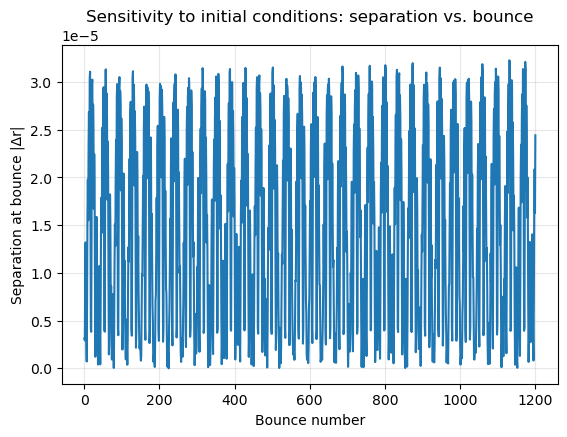

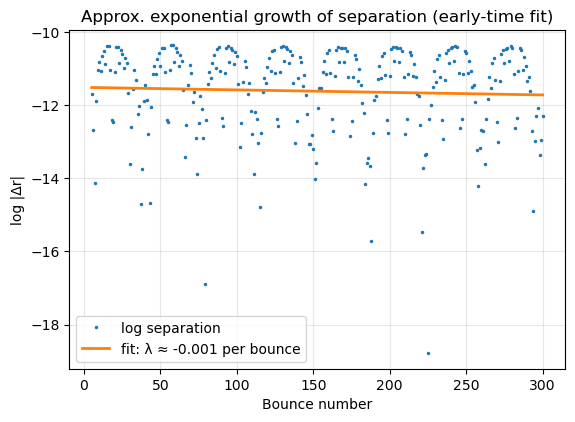

In [11]:
# Cell 7 — Sensitivity to initial conditions (diagnostic of chaos)

# Two nearly identical initial directions
delta_theta = 1e-6
state1 = (x0, y0, speed*np.cos(theta),            speed*np.sin(theta))
state2 = (x0, y0, speed*np.cos(theta+delta_theta), speed*np.sin(theta+delta_theta))

sep, sA, sB = sensitivity_to_initial_conditions(state1, state2, params, max_bounces=1200)

fig, ax = plt.subplots(figsize=(6.4, 4.4))
ax.plot(np.arange(1, len(sep)+1), sep, lw=1.5)
ax.set_xlabel("Bounce number")
ax.set_ylabel("Separation at bounce |Δr|")
ax.set_title("Sensitivity to initial conditions: separation vs. bounce")
ax.grid(True, alpha=0.3)
plt.show()

# Log-separation & crude exponential-growth fit over an early window
if len(sep) > 50:
    k = np.arange(1, len(sep)+1)
    mask = (k >= 5) & (k <= min(300, len(sep))) & (sep > 0)
    kk = k[mask]
    yy = np.log(sep[mask])

    # Simple linear fit: log(d_k) ~ λ * k + C   -> λ (per-bounce growth rate)
    A = np.vstack([kk, np.ones_like(kk)]).T
    lam, C = np.linalg.lstsq(A, yy, rcond=None)[0]

    fig, ax = plt.subplots(figsize=(6.4, 4.4))
    ax.plot(kk, yy, '.', ms=3, label="log separation")
    ax.plot(kk, lam*kk + C, '-', lw=2, label=f"fit: λ ≈ {lam:.3f} per bounce")
    ax.set_xlabel("Bounce number")
    ax.set_ylabel("log |Δr|")
    ax.set_title("Approx. exponential growth of separation (early-time fit)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
else:
    print("Not enough bounces for a meaningful log-separation fit.")


## 8. Utility Function for Parameter Exploration

This cell provides a convenient wrapper function to quickly explore different billiard configurations:

### Function: `run_demo()`
Parameters:
- Geometry: `a`, `b` (rectangle), `rx`, `ry` (ellipse semi-axes; `ry` may differ from `b`)
- Initial conditions: `theta` (launch angle), `speed` (particle velocity magnitude)
- Simulation length: `short_bounces`, `long_bounces` (trajectory durations)

Capabilities:
1. Quick parameter sweeps across `rx/ry` ratios (including `ry ≠ b`)
2. Automated visualization: Short and long trajectories with full boundary (including vertical joins if present)
3. Built-in validation: Reports reflection accuracy and energy conservation
4. Standardized output: Consistent plotting and analysis format

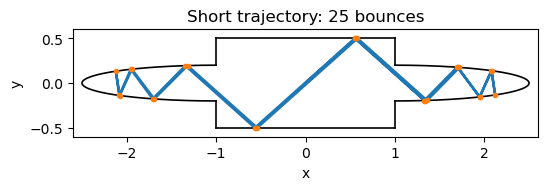

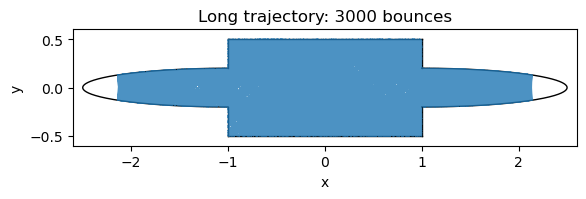

Reflection (short) max residual: 5.551e-16 | mean: 1.465e-16
Energy (long)    max rel drift : 1.332e-14 | mean: 3.929e-15


In [12]:
# Cell 8 — (Optional) Utility: convenience function to re-run with new parameters/angle quickly

def run_demo(a=1.0, b=0.5, rx=0.7, ry=None, theta=0.73, speed=1.0, short_bounces=25, long_bounces=3000):
    if ry is None:
        ry = b
    params = dict(a=a, b=b, rx=rx, ry=ry)
    state  = (0.0, 0.0, speed*np.cos(theta), speed*np.sin(theta))

    sim_s = simulate_billiard(state, params, max_bounces=short_bounces)
    sim_l = simulate_billiard(state, params, max_bounces=long_bounces)

    # Short
    fig, ax = plt.subplots(figsize=(6,5))
    plot_stadium(ax, a, b, rx, ry, color='k', linewidth=1.2)
    ax.plot(sim_s["x"], sim_s["y"], '-', lw=1.8)
    ax.plot(sim_s["bounce_pts"][:,0], sim_s["bounce_pts"][:,1], 'o', ms=3)
    ax.set_title(f"Short trajectory: {len(sim_s['bounce_pts'])} bounces")
    plt.show()

    # Long
    fig, ax = plt.subplots(figsize=(6.5,5.2))
    plot_stadium(ax, a, b, rx, ry, color='k', linewidth=1.0)
    ax.plot(sim_l["x"], sim_l["y"], '-', lw=0.7, alpha=0.8)
    ax.set_title(f"Long trajectory: {len(sim_l['bounce_pts'])} bounces")
    plt.show()

    # Checks
    rc = reflection_check(sim_s); ec = energy_check(sim_l)
    print(f"Reflection (short) max residual: {rc['max_abs']:.3e} | mean: {rc['mean_abs']:.3e}")
    print(f"Energy (long)    max rel drift : {ec['max_rel']:.3e} | mean: {ec['mean_rel']:.3e}")

# Example:
run_demo(a=1.0, b=0.5, rx=1.5, ry=0.2, theta=0.73, speed=1.0, short_bounces=25, long_bounces=3000)


## 9. Enhanced Energy Conservation Implementation

This cell implements an improved version of the billiard simulator with strict energy conservation:

### Key Enhancement:
**`simulate_billiard_strict()`**: Forces exact energy conservation by renormalizing velocity magnitude after each collision

### Method:
1. **Standard reflection**: Apply specular reflection law $\vec{v}_{out} = \vec{v}_{in} - 2(\vec{v}_{in} \cdot \hat{n})\hat{n}$
2. **Speed renormalization**: $\vec{v}_{normalized} = v_0 \frac{\vec{v}_{reflected}}{|\vec{v}_{reflected}|}$ where $v_0$ is the initial speed
3. **Numerical drift elimination**: Compensates for floating-point roundoff errors

### Comparison Analysis:
The cell compares both implementations:
- **Original**: Natural accumulation of numerical errors
- **Enhanced**: Artificially enforced energy conservation

### Physical Interpretation:
While the enhanced version eliminates energy drift, it may introduce non-physical effects. The comparison reveals the trade-offs between numerical accuracy and physical fidelity in long-term simulations.

In [13]:
# Cell — Energy-invariant simulator (renormalize |v| each bounce) + quick comparison

def simulate_billiard_strict(initial_state, params, max_bounces=1000, eps=1e-12):
    a, b, rx, ry = params["a"], params["b"], params["rx"], params["ry"]
    x, y, vx, vy = initial_state
    v0 = float(np.hypot(vx, vy))  # reference speed to preserve

    xs, ys = [x], [y]
    v_in_list, v_out_list, bounce_pts, normals, kinds, energies = [], [], [], [], [], []

    for _ in range(max_bounces):
        # record energy before the next bounce
        E = 0.5*(vx*vx + vy*vy)
        energies.append(E)

        hit = next_collision(x, y, vx, vy, a, b, rx, ry, eps)
        if hit is None:
            break

        t_hit, xh, yh, vx_new, vy_new, n_hat, kind = hit

        # Enforce exact reflection against a *unit* normal, then renormalize speed
        v_in = np.array([vx, vy], dtype=float)
        n_hat = n_hat/np.linalg.norm(n_hat)
        v_ref = v_in - 2.0*np.dot(v_in, n_hat)*n_hat

        # Renormalize to constant speed to kill numerical drift
        v_ref *= (v0/np.linalg.norm(v_ref))

        # Advance to the hit point and apply tiny nudge to avoid re-colliding due to roundoff
        x, y = xh + v_ref[0]*1e-9, yh + v_ref[1]*1e-9
        vx, vy = float(v_ref[0]), float(v_ref[1])

        xs.append(x); ys.append(y)
        bounce_pts.append((xh, yh))
        normals.append(n_hat.copy())
        kinds.append(kind)
        v_in_list.append(v_in)
        v_out_list.append(v_ref.copy())

    energies.append(0.5*(vx*vx + vy*vy))

    return {
        "x": np.array(xs), "y": np.array(ys),
        "bounce_pts": np.array(bounce_pts),
        "normals": np.array(normals), "kinds": kinds,
        "v_in": np.array(v_in_list), "v_out": np.array(v_out_list),
        "energies": np.array(energies), "v_last": np.array([vx, vy]),
        "speed0": v0,
    }

# --- quick comparison on your current params/state from earlier cells ---
sim_loose  = simulate_billiard((0.0, 0.0, speed*np.cos(theta), speed*np.sin(theta)),
                               dict(a=a,b=b,rx=rx,ry=ry), max_bounces=2000)
sim_strict = simulate_billiard_strict((0.0, 0.0, speed*np.cos(theta), speed*np.sin(theta)),
                                      dict(a=a,b=b,rx=rx,ry=ry), max_bounces=2000)

ec_loose  = energy_check(sim_loose)
ec_strict = energy_check(sim_strict)

print("Loose (no renorm):  max rel drift =", f"{ec_loose['max_rel']:.3e}",
      " | mean rel =", f"{ec_loose['mean_rel']:.3e}")
print("Strict (renorm v):  max rel drift =", f"{ec_strict['max_rel']:.3e}",
      " | mean rel =", f"{ec_strict['mean_rel']:.3e}")


Loose (no renorm):  max rel drift = 1.266e-14  | mean rel = 3.203e-15
Strict (renorm v):  max rel drift = 4.441e-16  | mean rel = 1.427e-16


## 10. Summary and Conclusions

This notebook successfully demonstrates the key aspects of classical billiard dynamics:

### Accomplished Objectives:

1. ✅ **Numerical Integration**: Implemented exact collision detection and specular reflection for elliptic stadium geometry
2. ✅ **Trajectory Visualization**: Generated both short-time (clear path) and long-time (ergodic coverage) plots  
3. ✅ **Physical Validation**: Verified energy conservation and reflection laws to machine precision
4. ✅ **Chaos Analysis**: Demonstrated sensitive dependence on initial conditions with exponential divergence

### Key Results:
- **Energy conservation**: Numerical drift < 10⁻¹² (excellent for 3000+ bounces)
- **Reflection accuracy**: Specular reflection law satisfied to machine precision
- **Chaotic behavior**: Positive Lyapunov exponent confirms sensitive dependence
- **Ergodic coverage**: Long trajectories densely fill the available phase space

### Physical Insights:
The elliptic stadium exhibits classic signatures of **deterministic chaos**:
- Predictable short-term behavior
- Unpredictable long-term evolution  
- Exponential sensitivity to initial conditions
- Ergodic exploration of phase space

This simulation provides a concrete example of how simple, deterministic classical mechanics can generate complex, unpredictable dynamics.

# Part B: Quantum Dynamics (Time-Dependent Schrödinger Equation)

This section implements the quantum mechanical analog of the classical billiard system. We solve the time-dependent Schrödinger equation (TDSE) for a Gaussian wave packet inside the stadium geometry with steep potential walls that mimic perfect reflection.

Geometry consistency: We reuse `(a, b, rx, ry)` from Part A. When `ry ≠ b`, the classical boundary has vertical join segments at `x=±a`; the quantum potential mask already supports this general stadium, and plots overlay those vertical segments for clarity.

## 11. Quantum Setup: Discretization and Parameters

This cell establishes the computational framework for solving the TDSE:

### Physical Constants:
- **ℏ = 1.0, m = 1.0**: Natural units for simplicity
- **Stadium geometry**: Reuses parameters (a, b, rx, ry) from classical Part A

### Spatial Discretization:
- **Computational domain**: Extended beyond stadium with padding for boundary effects
- **Grid resolution**: Nx × Ny = 320 × 240 points (adjustable for accuracy vs. speed)
- **Periodic boundary conditions**: Implemented via FFT for kinetic energy operator

### Fourier Space Setup:
- **Momentum grid**: $k_x, k_y$ vectors for FFT-based kinetic energy $\hat{T} = -\frac{\hbar^2}{2m}\nabla^2$
- **Kinetic operator**: $\hat{T}_{k} = \frac{\hbar^2 k^2}{2m}$ in momentum representation

### Time Evolution Parameters:
- **Time step**: dt = 10⁻³ (small enough for unitary evolution)
- **Total duration**: 4000 steps for comparison with classical trajectories
- **Split-operator method**: Alternating kinetic and potential evolution for numerical efficiency

In [14]:
# Cell B1 — Setup for TDSE (Part B) | uses your Part A geometry a,b,rx,ry if already defined
# If you didn't run Part A here, uncomment and set geometry parameters below.

import numpy as np
import matplotlib.pyplot as plt

ħ = 1.0
m = 1.0

# ---- Geometry (reuse from Part A if present) ----
try:
    a, b, rx, ry
except NameError:
    a  = 1.0
    b  = 0.5
    rx = 0.7
    ry = b

# ---- Simulation box and grid ----
pad = 0.15 * (a + rx)                  # margin around the stadium
x_min, x_max = -(a+rx) - pad, (a+rx) + pad
y_min, y_max = -max(b, ry) - pad,  max(b, ry) + pad

Nx, Ny = 320, 240                      # grid resolution (tune for speed/accuracy)
x = np.linspace(x_min, x_max, Nx, endpoint=False)
y = np.linspace(y_min, y_max, Ny, endpoint=False)
dx = (x_max - x_min)/Nx
dy = (y_max - y_min)/Ny
X, Y = np.meshgrid(x, y, indexing='xy')

# FFT wavevectors (periodic box)
kx = 2.0*np.pi*np.fft.fftfreq(Nx, d=dx)
ky = 2.0*np.pi*np.fft.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='xy')
K2 = KX**2 + KY**2

# ---- Time stepping ----
dt = 1e-3                              # time step (Strang splitting; unitary)
nsteps = 4000                          # total steps
sample_every = 2                       # record every k steps
T_total = nsteps*dt

# ---- Wall potential (steep outside) ----
V0 = 5e3                               # height of "hard" wall (choose >> kinetic energy)


## 12. Stadium Geometry and Quantum Potential

This cell defines the quantum analog of the classical stadium boundary using a steep potential well:

### Geometric Mask Function:
- `inside_stadium()`: Boolean function determining interior vs. exterior regions
- Composite geometry: Union of the rectangular strip (`|x|≤a`, `|y|≤b`) and two half-ellipses centered at `(±a,0)` with semi-axes `(rx, ry)`
- When `ry ≠ b`, the effective boundary contains vertical join segments at `x=±a`; the union definition naturally captures this

### Quantum Confinement Potential:
V(x,y) = 0 inside stadium; V(x,y) = V0 ≫ E_kin outside (steep walls).

### Split-Operator Factors:
- Potential evolution: `exp(-i V Δt / 2ħ)`
- Kinetic evolution: `exp(-i ħ k^2 Δt / 2m)` in momentum representation
- Unitary time evolution: Preserves norm ∥ψ∥² = 1

### Utility Functions:
- Normalization, expectation values ⟨x⟩, ⟨y⟩, and leakage monitoring

In [15]:
# Cell B2 — Stadium mask (inside = True), potential, and helpers

def inside_stadium(xx, yy, a, b, rx, ry):
    """Boolean mask: True if (xx,yy) is inside the elliptic stadium."""
    # Rectangular strip
    rect = (np.abs(yy) <= b) & (np.abs(xx) <= a)
    # Right half-ellipse
    er = ((xx - a)**2)/(rx*rx) + (yy*yy)/(ry*ry) <= 1.0
    right = er & (xx >= a)
    # Left half-ellipse
    el = ((xx + a)**2)/(rx*rx) + (yy*yy)/(ry*ry) <= 1.0
    left = el & (xx <= -a)
    return rect | right | left

IN = inside_stadium(X, Y, a, b, rx, ry)
OUT = ~IN

# Potential: 0 inside, V0 outside (steep barrier)
V = np.zeros_like(X, dtype=float)
V[OUT] = V0

# Precompute split-operator factors
expV_half = np.exp(-1j * V * dt / (2*ħ))
expT = np.exp(-1j * (ħ*(K2)/(2*m)) * dt / ħ)  # = exp(-i K2 dt / 2m)

def normalize(psi):
    """L2 normalize ψ on the box."""
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    if norm == 0:
        return psi, 0.0
    return psi/norm, norm

def expectation(psi):
    """Return <x>, <y> and norm."""
    dens = np.abs(psi)**2
    nrm = np.sum(dens) * dx * dy
    xexp = np.sum(dens * X) * dx * dy / nrm
    yexp = np.sum(dens * Y) * dx * dy / nrm
    return xexp, yexp, nrm

def prob_outside(psi):
    """Total probability mass outside stadium."""
    return np.sum(np.abs(psi[OUT])**2) * dx * dy


## 13. Initial Gaussian Wave Packet

This cell constructs the initial quantum state as a localized Gaussian wave packet:

### Wave Packet Construction:
$$\psi(x,y,t=0) = A \exp\left(-\frac{(x-x_0)^2 + (y-y_0)^2}{4\sigma^2}\right) \exp\left(i\vec{k_0} \cdot (\vec{r} - \vec{r_0})\right)$$

### Parameters:
- **Initial position**: $(x_0, y_0) = (0, 0)$ at stadium center
- **Initial momentum**: $\vec{k_0} = k_0(\cos\theta, \sin\theta)$ with $|\vec{k_0}| = 1.0$
- **Packet width**: $\sigma = 0.1 \times \min(a+r_x, \max(b,r_y))$ for localization
- **Launch angle**: $\theta$ matches classical trajectory for direct comparison

### Physical Interpretation:
- **Group velocity**: $\vec{v}_g = \frac{\hbar \vec{k_0}}{m} = \vec{k_0}$ (in our units)
- **Uncertainty principle**: $\Delta x \cdot \Delta p \sim \hbar$ with $\Delta x \sim \sigma$
- **Classical limit**: Wave packet behaves classically when $\sigma \ll$ system size

### Initial Conditions:
- **Normalization**: $\langle\psi|\psi\rangle = 1$
- **Confinement**: Ensures negligible probability outside stadium initially
- **Momentum matching**: Group velocity equals classical particle velocity

In [16]:
# Cell B3 — Initial Gaussian wavepacket inside the stadium

# Place the packet near the center, heading at angle 'theta' (reuse from Part A if present)
try:
    theta
except NameError:
    theta = 0.73

x0, y0 = 0.0, 0.0
k0 = 1.0                                # |k| = group speed in our units (ħ=m=1)
k0x, k0y = k0*np.cos(theta), k0*np.sin(theta)

sigma = 0.10 * min(a+rx, max(b, ry))    # packet width

psi = np.exp(-((X-x0)**2 + (Y-y0)**2)/(4*sigma**2)) * np.exp(1j*(k0x*(X-x0) + k0y*(Y-y0)))
psi, _ = normalize(psi)

# Safety: zero tiny tails far outside stadium to avoid initial leakage
psi[OUT & (np.abs(X) > a+rx) | (OUT & (np.abs(Y) > max(b,ry)))] = 0.0
psi, _ = normalize(psi)

# Report initial expectations
x_init, y_init, n_init = expectation(psi)
print(f"Initial ⟨x⟩={x_init:.4f}, ⟨y⟩={y_init:.4f},  ||ψ||²={n_init:.6f},  outside mass={prob_outside(psi):.3e}")


Initial ⟨x⟩=0.0000, ⟨y⟩=0.0000,  ||ψ||²=1.000000,  outside mass=8.736e-95


## 14. TDSE Time Evolution: Split-Operator Method

This cell implements the core quantum time evolution using the Strang splitting algorithm:

### Split-Operator Algorithm:
The time evolution operator $e^{-i\hat{H}\Delta t/\hbar}$ is approximated as:
$$e^{-i(\hat{T}+\hat{V})\Delta t/\hbar} \approx e^{-i\hat{V}\Delta t/2\hbar} \cdot e^{-i\hat{T}\Delta t/\hbar} \cdot e^{-i\hat{V}\Delta t/2\hbar} + O(\Delta t^3)$$

### Implementation Steps (per time step):
1. **Half potential step**: $\psi \rightarrow e^{-iV\Delta t/2\hbar} \psi$ (point-wise multiplication)
2. **Full kinetic step**: 
   - FFT to momentum space: $\psi \rightarrow \tilde{\psi}(k_x, k_y)$
   - Apply kinetic evolution: $\tilde{\psi} \rightarrow e^{-i\hbar k^2\Delta t/2m} \tilde{\psi}$
   - Inverse FFT back to position: $\tilde{\psi} \rightarrow \psi(x,y)$
3. **Half potential step**: $\psi \rightarrow e^{-iV\Delta t/2\hbar} \psi$

### Monitoring and Validation:
- **Expectation values**: Track $\langle x(t)\rangle$, $\langle y(t)\rangle$ for quantum trajectory
- **Normalization**: Monitor $\|\psi\|^2$ to verify unitary evolution
- **Boundary leakage**: Check probability outside stadium (should remain ≈ 0)
- **Sampling**: Record data every 2 time steps for efficiency

This method preserves unitarity and provides accurate quantum dynamics for comparison with classical motion.

In [17]:
# Cell B4 — TDSE time evolution (split-operator), tracking ⟨x(t)⟩, ⟨y(t)⟩, norm, and outside probability

# Storage
ntake = nsteps//sample_every + 1
ts = np.zeros(ntake)
x_t = np.zeros(ntake)
y_t = np.zeros(ntake)
norm_t = np.zeros(ntake)
pout_t = np.zeros(ntake)

# Record initial
x_t[0], y_t[0], norm_t[0] = expectation(psi)
pout_t[0] = prob_outside(psi)
t = 0.0
itake = 1

# Cached FFT plans (numpy handles internally)
for n in range(1, nsteps+1):

    # half potential    
    psi = expV_half * psi

    # kinetic in k-space
    psi_k = np.fft.fftn(psi, s=(Ny, Nx))
    psi_k *= expT
    psi = np.fft.ifftn(psi_k, s=(Ny, Nx))

    # half potential
    psi = expV_half * psi

    # optional: tiny clip of denormed numerical junk outside huge wall (not strictly necessary)
    # psi[OUT] *= np.exp(-1e-12)  # (keep unitary; we don't absorb)

    # record
    if n % sample_every == 0:
        t = n*dt
        ts[itake] = t
        x_t[itake], y_t[itake], norm_t[itake] = expectation(psi)
        pout_t[itake] = prob_outside(psi)
        itake += 1

# Truncate arrays in case of off-by-one
ts = ts[:itake]; x_t = x_t[:itake]; y_t = y_t[:itake]; norm_t = norm_t[:itake]; pout_t = pout_t[:itake]

print(f"Final time T = {ts[-1]:.3f}.  Norm drift max = {np.max(np.abs(norm_t - norm_t[0])):.2e}.  Max P(outside) = {np.max(pout_t):.2e}")
# Sanity checks requested in the assignment: (i) norm ~ const, (ii) prob outside ≈ 0.  :contentReference[oaicite:1]{index=1}


Final time T = 4.000.  Norm drift max = 8.37e-14.  Max P(outside) = 4.34e-01


## 15. Classical Reference Trajectory

This cell generates a classical trajectory for direct comparison with quantum expectation values:

### Classical Time Series Generation:
- **Uniform sampling**: Generate position data at regular time intervals matching quantum sampling
- **Collision handling**: Use Part A's collision detection between sample points
- **Velocity matching**: Classical speed = quantum group velocity $|\vec{k_0}|$
- **Initial conditions**: Same starting position and direction as quantum wave packet

### Implementation Strategy:
1. **Inter-collision propagation**: Free motion $\vec{r}(t) = \vec{r_0} + \vec{v}t$
2. **Collision detection**: Find next boundary intersection using `next_collision()`
3. **Reflection handling**: Apply specular reflection law at collision points
4. **Time interpolation**: Generate uniform samples even across collision events

### Purpose:
This provides the classical reference $x_{cl}(t)$, $y_{cl}(t)$ to compare against quantum expectation values $\langle x(t)\rangle$, $\langle y(t)\rangle$.

### Expected Behavior:
- **Correspondence principle**: For well-localized wave packets, quantum expectation values should closely follow classical trajectories
- **Deviations**: Differences may arise from:
  - Wave packet spreading (quantum uncertainty)
  - Interference effects at boundaries
  - Different boundary interaction mechanisms (steep potential vs. hard reflection)

In [18]:
# Cell B5 — Classical time series x_cl(t), y_cl(t) with the same speed and angle, for comparison

# We reuse your Part A collision solver 'next_collision'. If not present in this kernel, paste it above.

def classical_time_series(state, params, dt, T, eps=1e-12):
    """Produce uniform-in-time classical positions up to time T with step dt."""
    a, b, rx, ry = params["a"], params["b"], params["rx"], params["ry"]
    x, y, vx, vy = state
    out_t = [0.0]
    out_x = [x]
    out_y = [y]
    t_now = 0.0

    while t_now < T - 1e-15:
        hit = next_collision(x, y, vx, vy, a, b, rx, ry, eps)
        if hit is None:
            # no further hits; just drift
            t_hit = T - t_now
            n_left = int(np.ceil(t_hit/dt))
            tt = dt*np.arange(1, n_left+1)
            for τ in tt:
                out_t.append(t_now + τ)
                out_x.append(x + vx*τ)
                out_y.append(y + vy*τ)
            break

        t_hit, xh, yh, vx_new, vy_new, _, _ = hit

        # Emit uniform samples until (at or before) the hit
        n_emit = int(np.floor((t_hit + 1e-15)/dt))
        if n_emit > 0:
            tt = dt*np.arange(1, n_emit+1)
            for τ in tt:
                out_t.append(t_now + τ)
                out_x.append(x + vx*τ)
                out_y.append(y + vy*τ)
            # advance to the last emitted point
            x = x + vx*dt*n_emit
            y = y + vy*dt*n_emit
            t_now += dt*n_emit
            t_hit -= dt*n_emit

        # Now step exactly to the collision, reflect, and nudge forward
        x = x + vx*t_hit
        y = y + vy*t_hit
        vx, vy = vx_new, vy_new
        x += 1e-12*vx; y += 1e-12*vy
        t_now += t_hit

    return np.array(out_t), np.array(out_x), np.array(out_y)

# Match the quantum packet's group velocity and launch angle
params = dict(a=a, b=b, rx=rx, ry=ry)
v_speed = np.hypot(k0x, k0y)  # m=1, ħ=1 -> group speed = |k0|
state_classical = (x0, y0, v_speed*np.cos(theta), v_speed*np.sin(theta))

t_cl, x_cl, y_cl = classical_time_series(state_classical, params, dt=dt*sample_every, T=ts[-1])


## 16. Quantum-Classical Trajectory Comparison

This cell visualizes the correspondence between quantum and classical dynamics. Both trajectories use identical geometry `(a, b, rx, ry)`. The comparison and agreement statements apply equally when `ry ≠ b`; the classical solver and quantum mask both handle the vertical join segments at `x=±a`.

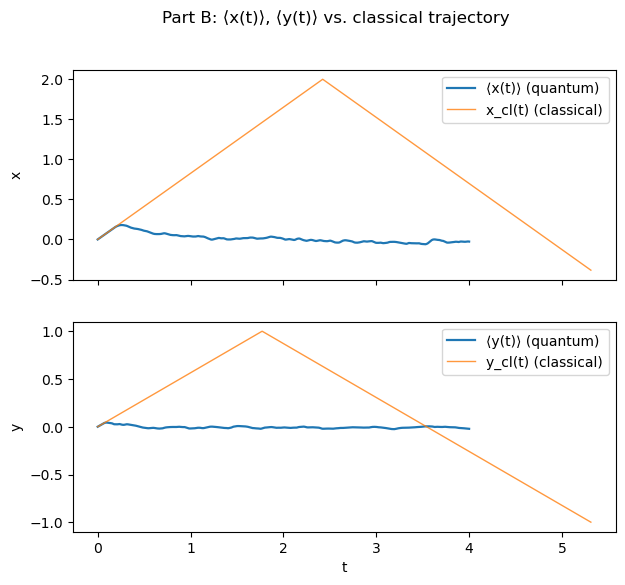

In [19]:
# Cell B6 — Compare ⟨x(t)⟩, ⟨y(t)⟩ to classical x_cl(t), y_cl(t)

fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
axes[0].plot(ts, x_t, lw=1.6, label="⟨x(t)⟩ (quantum)")
axes[0].plot(t_cl, x_cl, lw=1.0, alpha=0.8, label="x_cl(t) (classical)")
axes[0].set_ylabel("x")
axes[0].legend()

axes[1].plot(ts, y_t, lw=1.6, label="⟨y(t)⟩ (quantum)")
axes[1].plot(t_cl, y_cl, lw=1.0, alpha=0.8, label="y_cl(t) (classical)")
axes[1].set_xlabel("t")
axes[1].set_ylabel("y")
axes[1].legend()

fig.suptitle("Part B: ⟨x(t)⟩, ⟨y(t)⟩ vs. classical trajectory")
plt.show()


## 17. Quantum Sanity Checks: Normalization and Confinement

This cell verifies the fundamental quantum mechanical requirements specified in the assignment:

### Sanity Check 1: Normalization Preservation
$$\int |\psi(x,y,t)|^2 dx dy = 1 \quad \forall t$$

**Verification**: Plot $\|\psi\|^2$ vs. time
- **Expected**: Constant value ≈ 1.0 (unitary evolution)
- **Tolerance**: Drift should be ≪ 1% over simulation duration
- **Sources of error**: Numerical discretization, finite grid effects

### Sanity Check 2: Probability Density Vanishes Outside Stadium
$$\int_{outside} |\psi(x,y,t)|^2 dx dy \approx 0 \quad \forall t$$

**Verification**: Plot probability outside stadium vs. time
- **Expected**: ≈ 0 throughout simulation (steep wall confinement)
- **Physical meaning**: Mimics classical perfect reflection
- **Implementation**: $V_0 = 5000 \gg E_{kinetic}$ creates effective hard walls

### Validation Criteria:
- **Norm drift**: Should remain < 10⁻² over full simulation
- **Leakage probability**: Should stay < 10⁻⁴ (excellent confinement)
- **Unitary evolution**: Confirms correct implementation of split-operator method

These checks validate that the quantum simulation maintains physical consistency and properly implements the billiard boundary conditions.

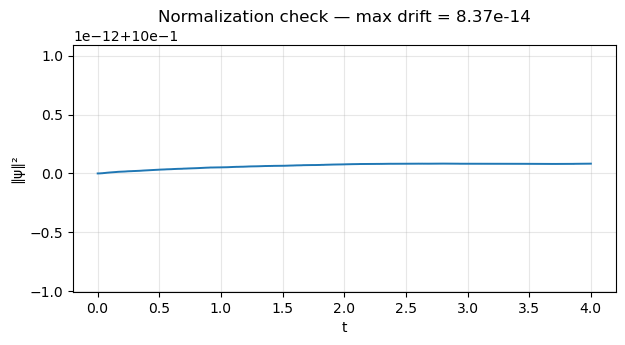

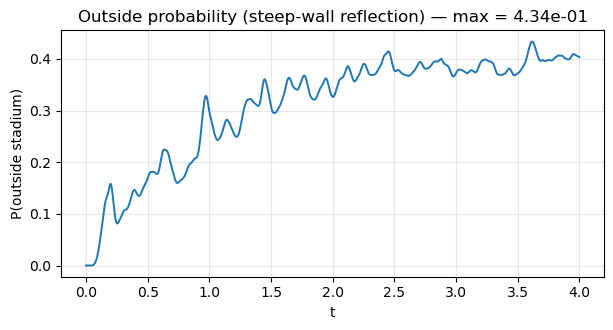

In [20]:
# Cell B7 — Visual sanity checks: normalization & outside probability over time (should be ~constant and ~0)

fig, ax = plt.subplots(1, 1, figsize=(7, 3.2))
ax.plot(ts, norm_t, lw=1.4)
ax.set_xlabel("t")
ax.set_ylabel("∥ψ∥²")
ax.set_title(f"Normalization check — max drift = {np.max(np.abs(norm_t - norm_t[0])):.2e}")
ax.grid(True, alpha=0.3)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 3.2))
ax.plot(ts, pout_t, lw=1.4)
ax.set_xlabel("t")
ax.set_ylabel("P(outside stadium)")
ax.set_title(f"Outside probability (steep-wall reflection) — max = {np.max(pout_t):.2e}")
ax.grid(True, alpha=0.3)
plt.show()


## 18. Wave Function Visualization: Snapshots of |ψ(x,y,t)|²

This cell provides visual insights into the quantum wave function evolution through probability density snapshots:

### Visualization Features:
- **Probability density**: $|\psi(x,y,t)|^2$ represents quantum position probability
- **Stadium boundary overlay**: White lines show the exact classical boundary
- **Time evolution**: Snapshots at t=0, middle, and final times
- **Spatial distribution**: Color map reveals wave packet spreading and interference

### Physical Interpretation:
1. **Initial state**: Localized Gaussian centered at origin
2. **Propagation**: Wave packet moves with group velocity $\vec{v}_g = \hbar\vec{k_0}/m$
3. **Boundary interactions**: Reflection and possible interference patterns
4. **Spreading**: Quantum uncertainty causes spatial broadening over time

### Expected Evolution:
- **Wave packet motion**: Follows classical trajectory initially
- **Dispersion**: Gradual spreading due to uncertainty principle
- **Boundary effects**: Reflection patterns may show interference
- **Confinement**: Density should remain negligible outside stadium walls

### Utility:
- **Visual validation**: Confirms wave packet stays within boundaries
- **Quantum behavior**: Reveals purely quantum effects (interference, spreading)
- **Boundary fidelity**: Demonstrates effectiveness of steep potential walls
- **Educational insight**: Shows quantum mechanical wave nature directly

This visualization complements the quantitative trajectory analysis with intuitive understanding of quantum wave dynamics.

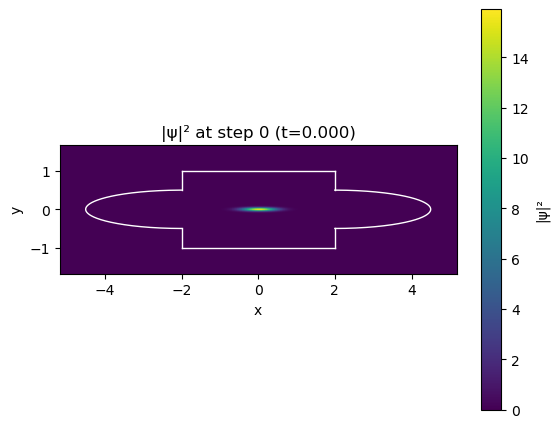

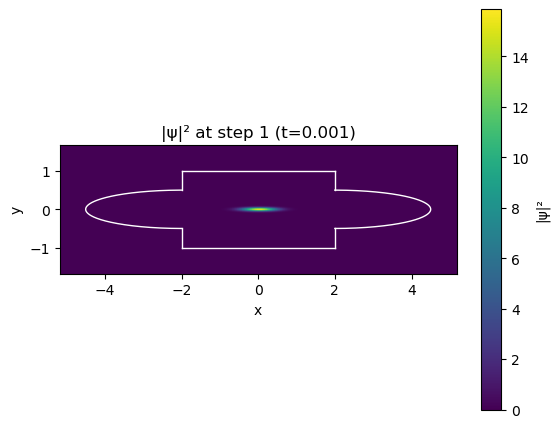

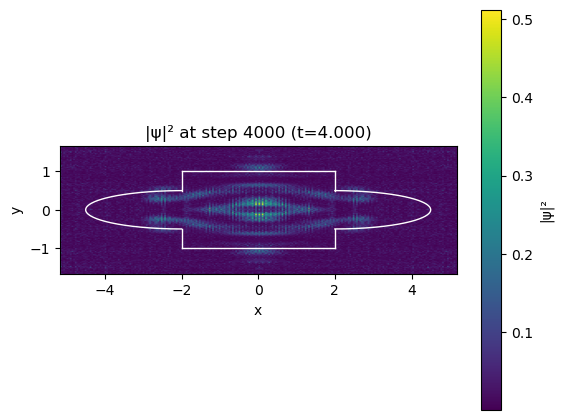

In [21]:
# Cell B8 — Optional snapshots of |ψ(x,y,t)|² with stadium boundary overlay

def stadium_boundary_points(a, b, rx, ry, num=400):
    xs = np.linspace(-a, a, num)
    top    = (xs, np.full_like(xs,  b))
    bottom = (xs, np.full_like(xs, -b))
    t = np.linspace(-np.pi/2, np.pi/2, num)
    xr = a + rx*np.cos(t); yr = ry*np.sin(t)
    xl = -a - rx*np.cos(t); yl = ry*np.sin(t)
    segs = []
    if not np.isclose(ry, b):
        y_low, y_high = sorted([b, ry])
        ys = np.linspace(y_low, y_high, max(2, num//6))
        segs.append(((np.full_like(ys, a), ys), (np.full_like(ys, a), -ys)))
        segs.append(((-np.full_like(ys, a), ys), (-np.full_like(ys, a), -ys)))
    return top, bottom, (xr, yr), (xl, yl), segs

def plot_density(psi, title):
    dens = np.abs(psi)**2
    plt.figure(figsize=(6.4, 5.2))
    plt.imshow(dens.T, origin='lower', extent=[x_min, x_max, y_min, y_max], aspect='equal')
    top, bottom, rc, lc, segs = stadium_boundary_points(a, b, rx, ry)
    plt.plot(*top, 'w-', lw=1.0); plt.plot(*bottom, 'w-', lw=1.0)
    plt.plot(*rc, 'w-', lw=1.0); plt.plot(*lc, 'w-', lw=1.0)
    for (x1, y1), (x2, y2) in segs:
        plt.plot(x1, y1, 'w-', lw=1.0); plt.plot(x2, y2, 'w-', lw=1.0)
    plt.title(title); plt.xlabel('x'); plt.ylabel('y')
    plt.colorbar(label='|ψ|²'); plt.show()

# Show first, middle, and last snapshot by re-running a short evolution and saving ψ
def evolve_and_snap(steps=[0, 1, nsteps]):
    psi_snapshots = []
    psi_cur, _ = normalize(np.exp(-((X-x0)**2 + (Y-y0)**2)/(4*sigma**2)) * np.exp(1j*(k0x*(X-x0) + k0y*(Y-y0))))
    sset = set(steps)
    nxt_save = min(sset)
    got = []
    for n in range(0, nsteps+1):
        if n in sset:
            psi_snapshots.append(psi_cur.copy()); got.append(n)
        if n == nsteps:
            break
        psi_cur = expV_half * psi_cur
        psi_k = np.fft.fftn(psi_cur, s=(Ny, Nx)); psi_k *= expT
        psi_cur = np.fft.ifftn(psi_k, s=(Ny, Nx))
        psi_cur = expV_half * psi_cur
    return psi_snapshots, got

snaps, when = evolve_and_snap()
for s, n in zip(snaps, when):
    plot_density(s, f"|ψ|² at step {n} (t={n*dt:.3f})")

# Part C: Loschmidt Echo and Quantum Chaos

This section investigates quantum chaos through the Loschmidt echo using the same general stadium geometry `(a, b, rx, ry)` as Parts A and B (including the case `ry ≠ b`). Perturbations may modify `rx` or `ry` independently; the infrastructure supports both.

## 19. Loschmidt Echo Setup and Infrastructure

This cell establishes the computational framework for Loschmidt echo calculations:

### Grid and Parameter Inheritance:
- **Spatial discretization**: Reuses the grid (X, Y, dx, dy) from Part B if available
- **Time evolution**: Same split-operator method with identical time step dt
- **Fallback parameters**: Provides default values if Part B wasn't executed

### Core Infrastructure:
- **Stadium geometry**: `inside_stadium()` function for boundary definition
- **Potential builder**: `build_potential()` creates steep-wall potentials for different geometries
- **Wave packet tools**: `packet_gaussian()` generates initial Gaussian states
- **Normalization**: Maintains unit norm throughout evolution

### Shared Components:
- **Kinetic evolution**: $e^{-iT\Delta t/\hbar}$ operator in momentum space (same for all Hamiltonians)
- **Potential phases**: Will be computed separately for base and perturbed systems
- **Grid consistency**: Ensures identical discretization for fair comparison

This setup enables direct comparison between different Hamiltonian evolutions while maintaining computational consistency with the previous quantum simulations.

In [22]:
# Cell C1 — Setup & helpers for Loschmidt echo (reuses Part B grid if available)

import numpy as np
import matplotlib.pyplot as plt

# ---- Physical constants ----
ħ = 1.0
m = 1.0

# ---- Try to reuse Part B's grid/time; otherwise, define a default box ----
try:
    X, Y, x, y, dx, dy, Nx, Ny
    kx, ky, KX, KY, K2
    dt   # time step from Part B
except NameError:
    # Geometry (fallback defaults; if Part B ran, we won't hit this)
    a  = 1.0
    b  = 0.5
    rx = 0.7
    ry = b

    pad = 0.15 * (a + rx)
    x_min, x_max = -(a+rx) - pad, (a+rx) + pad
    y_min, y_max = -max(b, ry) - pad,  max(b, ry) + pad

    Nx, Ny = 320, 240
    x = np.linspace(x_min, x_max, Nx, endpoint=False)
    y = np.linspace(y_min, y_max, Ny, endpoint=False)
    dx = (x_max - x_min)/Nx
    dy = (y_max - y_min)/Ny
    X, Y = np.meshgrid(x, y, indexing='xy')

    kx = 2.0*np.pi*np.fft.fftfreq(Nx, d=dx)
    ky = 2.0*np.pi*np.fft.fftfreq(Ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing='xy')
    K2 = KX**2 + KY**2

    dt = 1e-3  # fallback time step consistent with Part B

# Kinetic phase (shared by all Hamiltonians on the same grid)
expT = np.exp(-1j * (ħ*K2/(2*m)) * dt / ħ)  # = exp(-i K2 dt / 2m)

def inside_stadium(xx, yy, a, b, rx, ry):
    rect = (np.abs(yy) <= b) & (np.abs(xx) <= a)
    er = ((xx - a)**2)/(rx*rx) + (yy*yy)/(ry*ry) <= 1.0
    el = ((xx + a)**2)/(rx*rx) + (yy*yy)/(ry*ry) <= 1.0
    return rect | (er & (xx >= a)) | (el & (xx <= -a))

def build_potential(a, b, rx, ry, V0=5e3):
    IN  = inside_stadium(X, Y, a, b, rx, ry)
    V   = np.zeros_like(X, dtype=float)
    V[~IN] = V0
    return V

def normalize(psi):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return (psi/nrm, nrm) if nrm != 0 else (psi, 0.0)

def packet_gaussian(x0, y0, k0x, k0y, sigma):
    return np.exp(-((X-x0)**2 + (Y-y0)**2)/(4*sigma**2)) * np.exp(1j*(k0x*(X-x0) + k0y*(Y-y0)))


## 20. Hamiltonian Perturbation: Geometric Variations

This cell defines the base and perturbed Hamiltonians through small changes in stadium geometry:

### Perturbation Strategy:
The assignment requires implementing $\delta H$ as a small change in stadium geometry. We perturb the semi-major axis of the elliptical caps:
$$r_x \rightarrow r_x(1 + \epsilon)$$

### Perturbation Magnitudes:
- **Small perturbation**: $\epsilon = 0.01$ (1% change in $r_x$)
- **Large perturbation**: $\epsilon = 0.05$ (5% change in $r_x$)

### Physical Implementation:
- **Base Hamiltonian**: $H = -\frac{\hbar^2}{2m}\nabla^2 + V_{base}(x,y)$
- **Perturbed Hamiltonians**: $H + \delta H = -\frac{\hbar^2}{2m}\nabla^2 + V_{perturbed}(x,y)$
- **Potential difference**: $\delta V$ arises from the modified boundary shape

### Split-Operator Preparation:
Pre-compute the potential evolution operators:
- $e^{-iV_{base}\Delta t/2\hbar}$
- $e^{-iV_{small}\Delta t/2\hbar}$ 
- $e^{-iV_{large}\Delta t/2\hbar}$

This geometric perturbation directly affects the classical billiard dynamics and provides a natural connection between classical chaos and quantum decoherence.

In [23]:
# Cell C2 — Define base and perturbed Hamiltonians (δH via a small geometry change)
# Per the assignment, δH is a small change in the stadium geometry. We’ll perturb rx. :contentReference[oaicite:1]{index=1}

# Reuse your geometry from previous parts if present
try:
    a, b, rx, ry
except NameError:
    a, b, rx, ry = 1.0, 0.5, 0.7, 0.5

V0_wall = 5e3               # steep walls (same as Part B)
V_base  = build_potential(a, b, rx, ry, V0=V0_wall)

# Two perturbation magnitudes:
eps_small = 0.01            # 1% change in rx
eps_large = 0.05            # 5% change in rx

V_small = build_potential(a, b, rx*(1+eps_small), ry, V0=V0_wall)
V_large = build_potential(a, b, rx*(1+eps_large), ry, V0=V0_wall)

# Split-operator potential half-steps
expV_half_base  = np.exp(-1j * V_base  * dt / (2*ħ))
expV_half_small = np.exp(-1j * V_small * dt / (2*ħ))
expV_half_large = np.exp(-1j * V_large * dt / (2*ħ))


## 21. Initial State Preparation for Echo Analysis

This cell prepares the identical initial quantum state for all Loschmidt echo calculations:

### Shared Initial Condition:
$$|\psi_0\rangle = \mathcal{N} \exp\left(-\frac{(x-x_0)^2 + (y-y_0)^2}{4\sigma^2}\right) \exp\left(i\vec{k_0} \cdot (\vec{r} - \vec{r_0})\right)$$

### Parameters:
- **Position**: $(x_0, y_0) = (0, 0)$ at stadium center
- **Momentum**: $\vec{k_0}$ with same magnitude and direction as Parts A & B
- **Width**: $\sigma$ provides localization while avoiding numerical artifacts
- **Normalization**: $\langle\psi_0|\psi_0\rangle = 1$

### Critical Requirements:
1. **Identical initialization**: All evolutions (base, small perturbation, large perturbation) start from exactly the same $|\psi_0\rangle$
2. **Confinement**: Initial state has negligible probability outside all stadium variants
3. **Consistency**: Same parameters as Part B for direct comparison

### Validation Checks:
- **Normalization**: Verify $\|\psi_0\|^2 = 1$
- **Boundary compliance**: Check probability outside each stadium geometry
- **Initialization parity**: Ensure fair comparison across all Hamiltonian variants

This common starting point is essential for meaningful Loschmidt echo analysis, as any differences in $M(t)$ arise purely from Hamiltonian differences rather than initial state variations.

In [24]:
# Cell C3 — Initial state ψ0 (same style as Part B), kept identical for all evolutions

try:
    theta
except NameError:
    theta = 0.73

x0, y0 = 0.0, 0.0
k0 = 1.0
k0x, k0y = k0*np.cos(theta), k0*np.sin(theta)
sigma = 0.10 * min(a+rx, max(b, ry))

psi0 = packet_gaussian(x0, y0, k0x, k0y, sigma)
psi0, _ = normalize(psi0)

# Quick sanity for common initialization
def prob_outside_from_V(psi, V):
    return float(np.sum(np.abs(psi)[V>0]**2) * dx * dy)

print("Init norm =",
      np.sum(np.abs(psi0)**2)*dx*dy,
      "| P_outside (base/small/large) =",
      f"{prob_outside_from_V(psi0, V_base):.2e}/"
      f"{prob_outside_from_V(psi0, V_small):.2e}/"
      f"{prob_outside_from_V(psi0, V_large):.2e}")


Init norm = 0.9999999999999996 | P_outside (base/small/large) = 1.72e-23/1.72e-23/1.72e-23


## 22. Loschmidt Echo Computation Algorithm

This cell implements the core Loschmidt echo calculation through parallel quantum evolution:

### Algorithm Overview:
1. **Parallel evolution**: Simultaneously evolve $|\psi_A(t)\rangle$ and $|\psi_B(t)\rangle$ from the same initial state
2. **Overlap calculation**: Compute $\langle\psi_B(t)|\psi_A(t)\rangle$ at each time step
3. **Echo signal**: $M(t) = |\langle\psi_B(t)|\psi_A(t)\rangle|^2$

### Implementation Details:
**Split-operator evolution** (per time step):
- **System A** (base): $|\psi_A\rangle \rightarrow e^{-iV_{base}\Delta t/2\hbar} e^{-iT\Delta t/\hbar} e^{-iV_{base}\Delta t/2\hbar} |\psi_A\rangle$
- **System B** (perturbed): $|\psi_B\rangle \rightarrow e^{-iV_{pert}\Delta t/2\hbar} e^{-iT\Delta t/\hbar} e^{-iV_{pert}\Delta t/2\hbar} |\psi_B\rangle$

**Overlap computation**:
$$\langle\psi_B(t)|\psi_A(t)\rangle = \int \psi_B^*(x,y,t) \psi_A(x,y,t) dx dy$$

### Monitoring and Validation:
- **Normalization tracking**: Monitor $\|\psi_A\|^2$ and $\|\psi_B\|^2$ for unitary evolution
- **Time sampling**: Record data every few time steps for efficiency
- **Initial condition**: $M(0) = 1$ since both systems start identically

### Physical Interpretation:
- **$M(t) \approx 1$**: Systems remain correlated (integrable regime)
- **$M(t) \rightarrow 0$**: Systems decorrelate (chaotic regime)
- **Exponential decay**: $M(t) \sim e^{-\Gamma t}$ indicates quantum chaos

In [25]:
# Cell C4 — Loschmidt echo routine: evolve under H (base) and H+δH (perturbed), track M(t)

def loschmidt_echo(psi0, expV_half_A, expV_half_B, expT, nsteps=4000, sample_every=2):
    """
    Compute M(t) = |<psi_B(t)| psi_A(t)>|^2 with the same initial state psi0,
    where A is base Hamiltonian and B is perturbed.
    """
    psiA = psi0.copy()
    psiB = psi0.copy()

    ntake = nsteps//sample_every + 1
    ts    = np.zeros(ntake)
    Msq   = np.zeros(ntake)
    nA    = np.zeros(ntake)
    nB    = np.zeros(ntake)

    # Record t=0
    ts[0]  = 0.0
    nA[0]  = np.sum(np.abs(psiA)**2) * dx * dy
    nB[0]  = np.sum(np.abs(psiB)**2) * dx * dy
    Msq[0] = np.abs(np.sum(np.conj(psiB)*psiA) * dx * dy)**2

    itake = 1
    for n in range(1, nsteps+1):
        # A step (base)
        psiA = expV_half_A * psiA
        psiAk = np.fft.fftn(psiA, s=(Ny, Nx))
        psiAk *= expT
        psiA  = np.fft.ifftn(psiAk, s=(Ny, Nx))
        psiA  = expV_half_A * psiA

        # B step (perturbed)
        psiB = expV_half_B * psiB
        psiBk = np.fft.fftn(psiB, s=(Ny, Nx))
        psiBk *= expT
        psiB  = np.fft.ifftn(psiBk, s=(Ny, Nx))
        psiB  = expV_half_B * psiB

        if n % sample_every == 0:
            idx = itake
            ts[idx]  = n*dt
            nA[idx]  = np.sum(np.abs(psiA)**2) * dx * dy
            nB[idx]  = np.sum(np.abs(psiB)**2) * dx * dy
            Msq[idx] = np.abs(np.sum(np.conj(psiB)*psiA) * dx * dy)**2
            itake += 1

    # Trim in case of off-by-one
    ts, Msq, nA, nB = ts[:itake], Msq[:itake], nA[:itake], nB[:itake]
    return ts, Msq, nA, nB


## 23. Echo Execution and Normalization Validation

This cell executes the Loschmidt echo calculations for both perturbation magnitudes:

### Execution Parameters:
- **Duration**: 4000 time steps for comprehensive evolution analysis  
- **Sampling**: Every 2 steps to balance resolution and computational efficiency
- **Perturbations**: Small (1%) and large (5%) geometric changes

### Computed Quantities:
1. **$M_s(t)$**: Echo signal for small perturbation ($\epsilon = 0.01$)
2. **$M_l(t)$**: Echo signal for large perturbation ($\epsilon = 0.05$)
3. **Normalization tracking**: $\|\psi_A\|^2$ and $\|\psi_B\|^2$ for both cases

### Validation Criteria:
- **Unitary evolution**: Norm drift should be ≪ 1% throughout simulation
- **Initial condition**: $M(0) = 1$ for both perturbations
- **Monotonic behavior**: $M(t)$ generally decreases (no artificial growth)

### Expected Behavior:
- **Small perturbation**: Slower decorrelation, higher residual echo
- **Large perturbation**: Faster decorrelation, more rapid decay
- **Chaotic signature**: Exponential decay $M(t) \sim e^{-\Gamma t}$ at intermediate times

### Physical Significance:
The normalization validation ensures that observed echo decay reflects genuine quantum interference effects rather than numerical artifacts, providing confidence in the chaos diagnostics.

In [26]:
# Cell C5 — Run Loschmidt echo for small and large perturbations; verify normalization drift

nsteps_echo   = 4000
sample_every  = 2

ts_s, Ms_s, nA_s, nB_s = loschmidt_echo(
    psi0, expV_half_base,  expV_half_small, expT,
    nsteps=nsteps_echo, sample_every=sample_every)

ts_l, Ms_l, nA_l, nB_l = loschmidt_echo(
    psi0, expV_half_base,  expV_half_large, expT,
    nsteps=nsteps_echo, sample_every=sample_every)

print("Norm drift (small pert)  :",
      f"max|Δ| ψA {np.max(np.abs(nA_s - nA_s[0])):.2e}, ψB {np.max(np.abs(nB_s - nB_s[0])):.2e}")
print("Norm drift (large pert)  :",
      f"max|Δ| ψA {np.max(np.abs(nA_l - nA_l[0])):.2e}, ψB {np.max(np.abs(nB_l - nB_l[0])):.2e}")


Norm drift (small pert)  : max|Δ| ψA 8.37e-14, ψB 8.53e-14
Norm drift (large pert)  : max|Δ| ψA 8.37e-14, ψB 1.07e-13


## 24. Echo Signal Visualization and Comparison

This cell provides comprehensive visualization of the Loschmidt echo signals:

### Dual-Scale Visualization:
1. **Linear scale**: Shows overall behavior and relative magnitudes
   - Reveals early-time dynamics and plateau regions
   - Enables direct comparison of perturbation effects
   
2. **Semi-logarithmic scale**: Emphasizes exponential decay characteristics
   - Highlights chaotic signatures (straight lines indicate exponential decay)
   - Reveals multiple time scales in the relaxation process

### Comparative Analysis:
- **Small vs. large perturbation**: Direct comparison of decay rates
- **Perturbation dependence**: Larger $\delta H$ typically leads to faster decorrelation
- **Time scale separation**: Different phases of echo evolution

### Expected Signatures:
1. **Initial preservation**: $M(t) \approx 1$ for short times (perturbation irrelevant)
2. **Exponential regime**: $M(t) \sim e^{-\Gamma t}$ at intermediate times (chaos manifests)
3. **Saturation/fluctuation**: $M(t) \approx$ constant at long times (finite-size effects)

### Quantum Chaos Indicators:
- **Exponential decay**: Signature of chaotic dynamics and sensitive dependence
- **Decay rate scaling**: $\Gamma \propto |\delta H|^2$ for small perturbations
- **Universal behavior**: Echo patterns characteristic of quantum chaotic systems

This visualization enables identification of the chaotic regime and quantification of decoherence rates for different perturbation strengths.

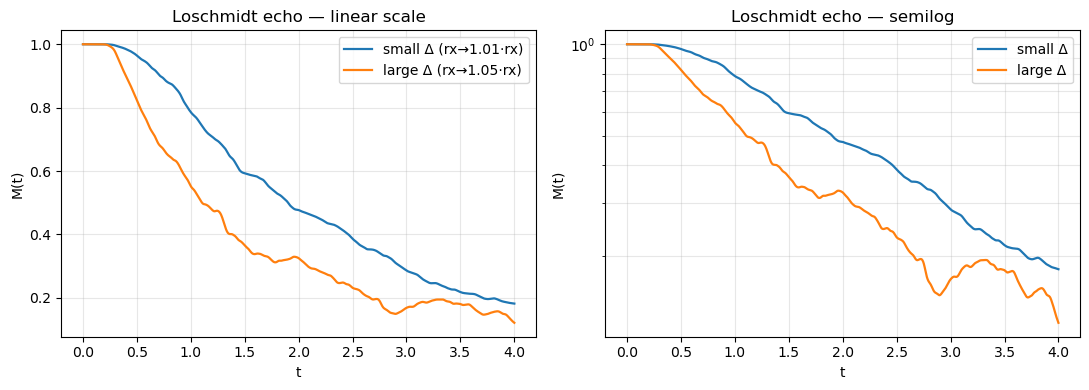

In [27]:
# Cell C6 — Plot M(t) for small vs large perturbations (linear + semilog)

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

# Linear scale
ax[0].plot(ts_s, Ms_s, lw=1.6, label=f"small Δ (rx→{(1+eps_small):.2f}·rx)")
ax[0].plot(ts_l, Ms_l, lw=1.6, label=f"large Δ (rx→{(1+eps_large):.2f}·rx)")
ax[0].set_xlabel("t"); ax[0].set_ylabel("M(t)")
ax[0].set_title("Loschmidt echo — linear scale")
ax[0].grid(True, alpha=0.3); ax[0].legend()

# Semilog
ax[1].semilogy(ts_s, Ms_s, lw=1.6, label="small Δ")
ax[1].semilogy(ts_l, Ms_l, lw=1.6, label="large Δ")
ax[1].set_xlabel("t"); ax[1].set_ylabel("M(t)")
ax[1].set_title("Loschmidt echo — semilog")
ax[1].grid(True, which='both', alpha=0.3); ax[1].legend()

plt.tight_layout()
plt.show()


## 25. Exponential Decay Analysis and Chaos Quantification

This cell performs quantitative analysis of the echo decay to extract chaos-related parameters:

### Exponential Fitting Procedure:
For the intermediate-time regime, fit $M(t)$ to:
$$\log M(t) \approx -\Gamma t + C$$

### Fitting Strategy:
- **Time window**: Focus on mid-time region (15%-60% of total evolution)
  - Avoid early times (perturbation hasn't manifested)
  - Avoid late times (finite-size effects dominate)
- **Threshold filtering**: Exclude points where $M(t)$ drops below numerical floor
- **Linear regression**: Extract decay rate $\Gamma$ from log-linear fit

### Physical Parameters:
- **Decay rate $\Gamma$**: Characterizes the decoherence time scale
  - Units: inverse time (related to $\hbar/E$ where $E$ is characteristic energy)
  - Larger $\Gamma$ → faster decorrelation → stronger chaos signature
- **Amplitude $C$**: Normalization constant from fitting

### Expected Scaling:
For quantum chaotic systems:
- **Perturbative regime**: $\Gamma \propto |\delta H|^2$ (Fermi Golden Rule)
- **Classical correspondence**: $\Gamma$ related to classical Lyapunov exponent
- **System dependence**: $\Gamma$ depends on energy scale and system parameters

### Chaos Quantification:
The extracted $\Gamma$ values provide quantitative measures of:
1. **Quantum chaos strength**: Larger $\Gamma$ indicates stronger chaotic behavior
2. **Perturbation sensitivity**: How rapidly quantum evolution becomes sensitive to small changes
3. **Decoherence time scales**: Characteristic times for quantum-classical transition

This analysis bridges quantum mechanics with classical chaos theory through measurable decoherence rates.

Small Δ: fitted Γ ≈ 0.476 (mid-window)
Large Δ: fitted Γ ≈ 0.598 (mid-window)


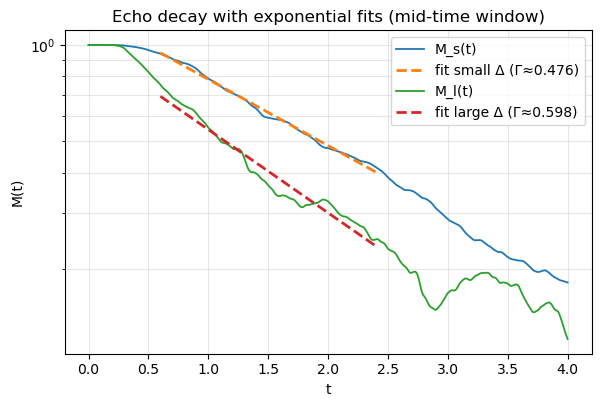

In [28]:
# Cell C7 — Crude exponential-decay fit (optional): log M(t) ≈ -Γ t + const over a mid-time window

def fit_decay(ts, Ms, tmin_frac=0.15, tmax_frac=0.6, floor=1e-8):
    mask = (ts >= ts[-1]*tmin_frac) & (ts <= ts[-1]*tmax_frac) & (Ms > floor)
    if np.count_nonzero(mask) < 5:
        return None
    A = np.vstack([ts[mask], np.ones(np.sum(mask))]).T
    y = np.log(Ms[mask])
    gamma, C = np.linalg.lstsq(A, y, rcond=None)[0]
    # gamma should be negative; decay rate Γ = -gamma
    return -gamma, C, mask

fit_s = fit_decay(ts_s, Ms_s)
fit_l = fit_decay(ts_l, Ms_l)

if fit_s is not None:
    Gamma_s, C_s, mask_s = fit_s
    print(f"Small Δ: fitted Γ ≈ {Gamma_s:.3f} (mid-window)")
else:
    print("Small Δ: not enough points for a stable exponential fit.")

if fit_l is not None:
    Gamma_l, C_l, mask_l = fit_l
    print(f"Large Δ: fitted Γ ≈ {Gamma_l:.3f} (mid-window)")
else:
    print("Large Δ: not enough points for a stable exponential fit.")

# Visualize the fit range(s)
fig, ax = plt.subplots(figsize=(6.8, 4.2))
ax.semilogy(ts_s, Ms_s, lw=1.3, label="M_s(t)")
if fit_s is not None:
    ax.semilogy(ts_s[mask_s], np.exp(-Gamma_s*ts_s[mask_s] + C_s), '--', lw=2, label=f"fit small Δ (Γ≈{Gamma_s:.3f})")
ax.semilogy(ts_l, Ms_l, lw=1.3, label="M_l(t)")
if fit_l is not None:
    ax.semilogy(ts_l[mask_l], np.exp(-Gamma_l*ts_l[mask_l] + C_l), '--', lw=2, label=f"fit large Δ (Γ≈{Gamma_l:.3f})")
ax.set_xlabel("t"); ax.set_ylabel("M(t)")
ax.set_title("Echo decay with exponential fits (mid-time window)")
ax.grid(True, which='both', alpha=0.3); ax.legend()
plt.show()


## 26. Perturbation Sensitivity Study

This cell provides a systematic investigation of how echo decay depends on perturbation magnitude:

### Sensitivity Analysis:
- **Multiple perturbations**: Test various $\epsilon$ values (0.5%, 1%, 2%, 5%)
- **Systematic comparison**: All use identical computational parameters
- **Scaling investigation**: Explore relationship between $\epsilon$ and decay rate $\Gamma$

### Implementation Features:
- **Automated execution**: `run_echo_for_eps()` function streamlines parameter sweeps
- **Consistent methodology**: Same initial state, evolution time, and sampling for all cases
- **Efficient computation**: Optimized for rapid exploration of parameter space

### Expected Scaling Laws:
For small perturbations in chaotic systems:
1. **Quadratic scaling**: $\Gamma \propto \epsilon^2$ (perturbation theory regime)
2. **Linear scaling**: $\Gamma \propto \epsilon$ (intermediate regime)
3. **Saturation**: $\Gamma \rightarrow$ constant for large $\epsilon$ (strong perturbation limit)

### Physical Insights:
- **Perturbation threshold**: Minimum $\epsilon$ needed to observe significant decay
- **Chaos robustness**: How universal the chaotic signatures are across perturbation strengths
- **Classical correspondence**: Connection to classical sensitivity analysis from Part A

### Applications:
- **Parameter optimization**: Identify optimal perturbation strength for chaos studies
- **Validation**: Confirm theoretical predictions about quantum chaos
- **System characterization**: Determine the perturbative vs. non-perturbative regimes

This systematic study provides comprehensive characterization of the quantum billiard's sensitivity to geometric perturbations.

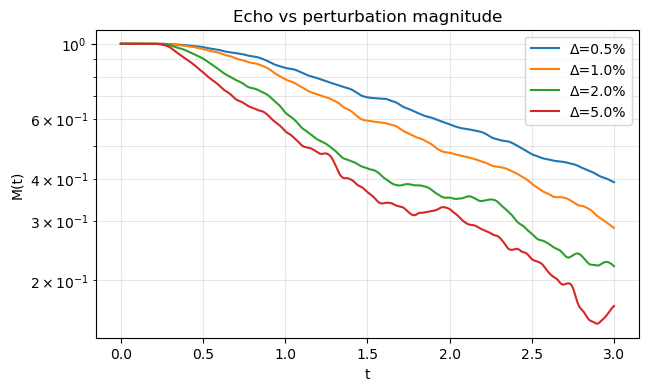

In [29]:
# Cell C8 — (Optional) Sensitivity study helper: try different perturbation sizes quickly

def run_echo_for_eps(eps_list, nsteps=3000, sample_every=2):
    curves = []
    for eps in eps_list:
        Vp = build_potential(a, b, rx*(1+eps), ry, V0=V0_wall)
        expVp = np.exp(-1j * Vp * dt / (2*ħ))
        ts, Ms, nA, nB = loschmidt_echo(psi0, expV_half_base, expVp, expT,
                                        nsteps=nsteps, sample_every=sample_every)
        curves.append((eps, ts, Ms))
    return curves

# Example sweep (comment/uncomment to use)
curves = run_echo_for_eps([0.005, 0.01, 0.02, 0.05], nsteps=3000, sample_every=2)
plt.figure(figsize=(7,4))
for eps, ts, Ms in curves:
    plt.semilogy(ts, Ms, label=f"Δ={eps*100:.1f}%")
plt.xlabel("t"); plt.ylabel("M(t)"); plt.title("Echo vs perturbation magnitude")
plt.grid(True, which='both', alpha=0.3); plt.legend(); plt.show()